In [1]:
# Cell 0: Install Required Packages

# Uncomment and run the following lines if the packages are not already installed.
# You can comment them out after the first run to avoid unnecessary installations.

!pip install dpkt
!pip install torch torchvision torchaudio
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn# Cell 0: Install Required Libraries

!pip install yfinance
!pip install seaborn
!pip install torch
!pip install scikit-learn


  Using cached dpkt-1.9.8-py3-none-any.whl.metadata (1.7 kB)
Using cached dpkt-1.9.8-py3-none-any.whl (194 kB)
ERROR: Invalid requirement: 'scikit-learn#'
  Using cached yfinance-0.2.50-py2.py3-none-any.whl.metadata (5.5 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached lxml-5.3.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (3.8 kB)
  Using cached frozendict-2.4.6-py311-none-any.whl.metadata (23 kB)
  Using cached peewee-3.17.8-cp311-cp311-linux_x86_64.whl
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
Using cached yfinance-0.2.50-py2.py3-none-any.whl (102 kB)
Using cached frozendict-2.4.6-py311-none-any.whl (16 kB)
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
Using cached lxml-5.3.0-cp311-cp311-manylinux_2_28_x86_64.whl (5.0 MB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)


In [66]:
# Cell 1: Import Required Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import datetime
import seaborn as sns
%matplotlib inline


In [67]:
# Cell 2: Download Market Data Using Yahoo Finance

# Parameters
ticker = 'SPY'  # You can change this to any ticker symbol you prefer
start_date = '2024-11-18'
end_date = '2024-11-22'
interval = '1m'  # 1-minute intervals

# Download the data
print("Downloading data...")
data = yf.download(tickers=ticker, start=start_date, end=end_date, interval=interval, progress=False)

# Check if data is retrieved
if data.empty:
    raise ValueError("No data fetched. Please check the ticker symbol and date range.")

# Reset index to have 'Datetime' as a column
data.reset_index(inplace=True)

# Display the first few rows
print("First few rows of the downloaded data:")
display(data.head())


First few rows of the downloaded data:


Price,Datetime,Adj Close,Close,High,Low,Open,Volume
Ticker,,SPY,SPY,SPY,SPY,SPY,SPY
0,2024-11-18 14:30:00+00:00,585.760010,585.760010,586.239990,585.760010,586.219971,1202061
1,2024-11-18 14:31:00+00:00,585.585022,585.585022,585.780029,585.460022,585.780029,135670
2,2024-11-18 14:32:00+00:00,585.445190,585.445190,585.640015,585.440002,585.604980,104981
3,2024-11-18 14:33:00+00:00,585.511475,585.511475,585.659912,585.340027,585.440002,133048
4,2024-11-18 14:34:00+00:00,585.539978,585.539978,585.650024,585.440002,585.510010,104455


In [68]:
# Cell 3: Preprocess and Feature Engineering

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Sort data by datetime just in case
data = data.sort_values('Datetime')

# Reset index
data.reset_index(drop=True, inplace=True)

# Create additional features if necessary
# For simplicity, we'll use Open, High, Low, Close, Volume
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = data[features]

# Handle missing values if any
print("Checking for missing values in the data...")
if data.isnull().values.any():
    print("Data contains NaN values. Filling missing values using forward fill.")
    data.fillna(method='ffill', inplace=True)
else:
    print("No missing values found.")

# Calculate mid_price as the average of High and Low
data['mid_price'] = (data['High'] + data['Low']) / 2.0

# Features to be used
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'mid_price']
data = data[feature_columns]

# Check for NaNs or Infs in mid_price
print("Checking for NaN or Inf values in mid_price...")
if data['mid_price'].isnull().any() or np.isinf(data['mid_price']).any():
    print("mid_price contains NaN or Inf values. Handling them.")
    data['mid_price'].fillna(method='ffill', inplace=True)
    data['mid_price'].replace([np.inf, -np.inf], 0, inplace=True)
else:
    print("mid_price is clean.")

# Convert to numpy array
data_values = data.values

# Check for NaNs or Infs in data_values
print("Checking for NaN or Inf values in data_values...")
if np.isnan(data_values).any() or np.isinf(data_values).any():
    print("data_values contains NaN or Inf values. Handling them.")
    data_values = np.nan_to_num(data_values, nan=0.0, posinf=0.0, neginf=0.0)
else:
    print("data_values is clean.")

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
print("Scaling the data...")
try:
    data_scaled = scaler.fit_transform(data_values)
except Exception as e:
    raise ValueError(f"Error during scaling: {e}")

# Check for NaNs or Infs in data_scaled
print("Checking for NaN or Inf values in data_scaled...")
if np.isnan(data_scaled).any() or np.isinf(data_scaled).any():
    print("data_scaled contains NaN or Inf values. Handling them.")
    data_scaled = np.nan_to_num(data_scaled, nan=0.0, posinf=0.0, neginf=0.0)
else:
    print("data_scaled is clean.")

# Compute unscaled price changes
mid_prices = data['mid_price'].values  # Unscaled mid_prices
price_changes_unscaled = mid_prices[1:] - mid_prices[:-1]  # Actual price changes

# Check for NaNs or Infs in price_changes_unscaled
print("Checking for NaN or Inf values in price_changes_unscaled...")
if np.isnan(price_changes_unscaled).any() or np.isinf(price_changes_unscaled).any():
    print("price_changes_unscaled contains NaN or Inf values. Handling them.")
    price_changes_unscaled = np.nan_to_num(price_changes_unscaled, nan=0.0, posinf=0.0, neginf=0.0)
else:
    print("price_changes_unscaled is clean.")

# Parameters
window_size = 100  # Number of timesteps for the transformer input window (~100 minutes)
forecast_horizon = 1  # Predict 1 step ahead

# Create input windows and targets
print("Creating input windows and targets...")
X = []
y = []
for i in range(len(data_scaled) - window_size - forecast_horizon):
    window = data_scaled[i:i + window_size]
    target = data_scaled[i + window_size][5]  # mid_price is at index 5

    # Check if window or target contains NaNs or Infs
    if np.isnan(window).any() or np.isinf(window).any() or np.isnan(target) or np.isinf(target):
        continue  # Skip this window
    X.append(window)
    y.append(target)

X = np.array(X)  # Shape: [N, window_size, features]
y = np.array(y)  # Shape: [N]

print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Compute aligned unscaled price changes
price_changes_aligned = price_changes_unscaled[window_size - 1: window_size - 1 + len(y)]
print(f"Aligned Unscaled Price Changes shape: {price_changes_aligned.shape}")


Checking for missing values in the data...
No missing values found.
Checking for NaN or Inf values in mid_price...
mid_price is clean.
Checking for NaN or Inf values in data_values...
data_values is clean.
Scaling the data...
Checking for NaN or Inf values in data_scaled...
data_scaled is clean.
Checking for NaN or Inf values in price_changes_unscaled...
price_changes_unscaled is clean.
Creating input windows and targets...
Input shape: (1452, 100, 6)
Target shape: (1452,)
Aligned Unscaled Price Changes shape: (1452,)


In [69]:
# Cell 4: Split Data into Training and Testing Sets

# Define the split ratio
train_size = int(0.8 * len(X))

# Split the data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
price_changes_train, price_changes_test = price_changes_aligned[:train_size], price_changes_aligned[train_size:]

print(f"Training Input shape: {X_train.shape}")
print(f"Training Target shape: {y_train.shape}")
print(f"Testing Input shape: {X_test.shape}")
print(f"Testing Target shape: {y_test.shape}")
print(f"Training Price Changes shape: {price_changes_train.shape}")
print(f"Testing Price Changes shape: {price_changes_test.shape}")

# Function to check for NaNs or Infs
def check_no_nan_inf(array, name):
    if np.isnan(array).any() or np.isinf(array).any():
        print(f"{name} contains NaN or Inf values.")
    else:
        print(f"{name} is clean.")

check_no_nan_inf(X_train, "X_train")
check_no_nan_inf(y_train, "y_train")
check_no_nan_inf(X_test, "X_test")
check_no_nan_inf(y_test, "y_test")


Training Input shape: (1161, 100, 6)
Training Target shape: (1161,)
Testing Input shape: (291, 100, 6)
Testing Target shape: (291,)
Training Price Changes shape: (1161,)
Testing Price Changes shape: (291,)
X_train is clean.
y_train is clean.
X_test is clean.
y_test is clean.


In [70]:
# Cell 5: Create PyTorch Datasets and DataLoaders

from torch.utils.data import Dataset, DataLoader
import torch

class PriceDataset(Dataset):
    def __init__(self, X, y):
        """
        Initialize the dataset with input features and targets.
        """
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = PriceDataset(X_train, y_train)
test_dataset = PriceDataset(X_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Final integrity checks on datasets
def torch_check_no_nan_inf(tensor, name):
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        print(f"{name} contains NaN or Inf values.")
    else:
        print(f"{name} is clean.")

# Check first batch in train_loader
sample_X, sample_y = next(iter(train_loader))
torch_check_no_nan_inf(sample_X, "Sample batch_X")
torch_check_no_nan_inf(sample_y, "Sample batch_y")


Number of training samples: 1161
Number of testing samples: 291
Sample batch_X is clean.
Sample batch_y is clean.


In [71]:
# Cell 6: Define the Transformer Model

import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, feature_size=6, d_model=32, nhead=4, num_layers=2, dim_feedforward=64, dropout=0.1):
        """
        Initialize the Transformer model.
        
        Parameters:
        - feature_size: Number of input features.
        - d_model: Dimension of the transformer model.
        - nhead: Number of attention heads.
        - num_layers: Number of transformer encoder layers.
        - dim_feedforward: Dimension of the feedforward network.
        - dropout: Dropout rate.
        """
        super().__init__()
        self.input_linear = nn.Linear(feature_size, d_model)
        
        # Initialize input_linear weights
        nn.init.xavier_uniform_(self.input_linear.weight)
        nn.init.zeros_(self.input_linear.bias)
        
        # Define transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                   dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer to predict the next mid_price
        self.fc_out = nn.Linear(d_model, 1)
        
        # Initialize fc_out weights
        nn.init.xavier_uniform_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)
        
    def forward(self, x):
        """
        Forward pass of the model.
        
        Parameters:
        - x: Input tensor of shape [batch, seq, features]
        
        Returns:
        - Predicted mid_price changes
        """
        # Project features into transformer embedding space
        x = self.input_linear(x)  # [batch, seq, d_model]
        
        # Transformer expects input shape: [seq, batch, d_model]
        x = x.permute(1, 0, 2)
        
        # Pass through transformer encoder
        out = self.transformer_encoder(x)  # [seq, batch, d_model]
        
        # Take the output from the last time step
        out = out[-1, :, :]  # [batch, d_model]
        
        # Predict the next mid_price
        out = self.fc_out(out)  # [batch, 1]
        
        return out.squeeze()  # [batch]


In [72]:
# Cell 7: Initialize and Train the Transformer Model

import torch.optim as optim

# Initialize the model
model = TransformerModel()

# Initialize loss function and optimizer with a lower learning rate
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Reduced learning rate

# Define gradient clipping value
GRAD_CLIP = 1.0

# Verify model predictions before training
model.eval()
with torch.no_grad():
    try:
        sample_X, sample_y = next(iter(train_loader))
    except StopIteration:
        raise ValueError("Training data loader is empty.")
    
    # Check for NaNs or Infs in the sample batch
    if torch.isnan(sample_X).any() or torch.isinf(sample_X).any():
        raise ValueError("Sample batch_X contains NaN or Inf values.")
    if torch.isnan(sample_y).any() or torch.isinf(sample_y).any():
        raise ValueError("Sample batch_y contains NaN or Inf values.")
    
    # Perform a forward pass to ensure model predictions are valid
    sample_pred = model(sample_X)
    if torch.isnan(sample_pred).any() or torch.isinf(sample_pred).any():
        raise ValueError("Model predictions contain NaN or Inf values.")
    
    print("Initial model predictions are valid.")

# Training loop
num_epochs = 20  # Increased epochs for better training

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        # Check for NaNs or Infs in the batch
        if torch.isnan(batch_X).any() or torch.isinf(batch_X).any():
            raise ValueError("batch_X contains NaN or Inf values.")
        if torch.isnan(batch_y).any() or torch.isinf(batch_y).any():
            raise ValueError("batch_y contains NaN or Inf values.")
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        
        # Check for NaNs or Infs in predictions
        if torch.isnan(predictions).any() or torch.isinf(predictions).any():
            raise ValueError("Model predictions contain NaN or Inf values.")
        
        loss = criterion(predictions, batch_y)
        
        # Check for NaNs or Infs in loss
        if torch.isnan(loss).item() or torch.isinf(loss).item():
            raise ValueError("Loss is NaN or Inf.")
        
        loss.backward()
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        
        optimizer.step()
        total_loss += loss.item() * len(batch_X)
    
    avg_loss = total_loss / len(train_dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.6f}")


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Initial model predictions are valid.
Epoch 1/20, Training Loss: 2.475137
Epoch 2/20, Training Loss: 0.805269
Epoch 3/20, Training Loss: 0.292374
Epoch 4/20, Training Loss: 0.160616
Epoch 5/20, Training Loss: 0.135452
Epoch 6/20, Training Loss: 0.120009
Epoch 7/20, Training Loss: 0.099624
Epoch 8/20, Training Loss: 0.098960
Epoch 9/20, Training Loss: 0.089561
Epoch 10/20, Training Loss: 0.085889
Epoch 11/20, Training Loss: 0.079280
Epoch 12/20, Training Loss: 0.077007
Epoch 13/20, Training Loss: 0.073522
Epoch 14/20, Training Loss: 0.064160
Epoch 15/20, Training Loss: 0.061548
Epoch 16/20, Training Loss: 0.054031
Epoch 17/20, Training Loss: 0.057170
Epoch 18/20, Training Loss: 0.053171
Epoch 19/20, Training Loss: 0.051016
Epoch 20/20, Training Loss: 0.046446


Test MSE: 1.999268


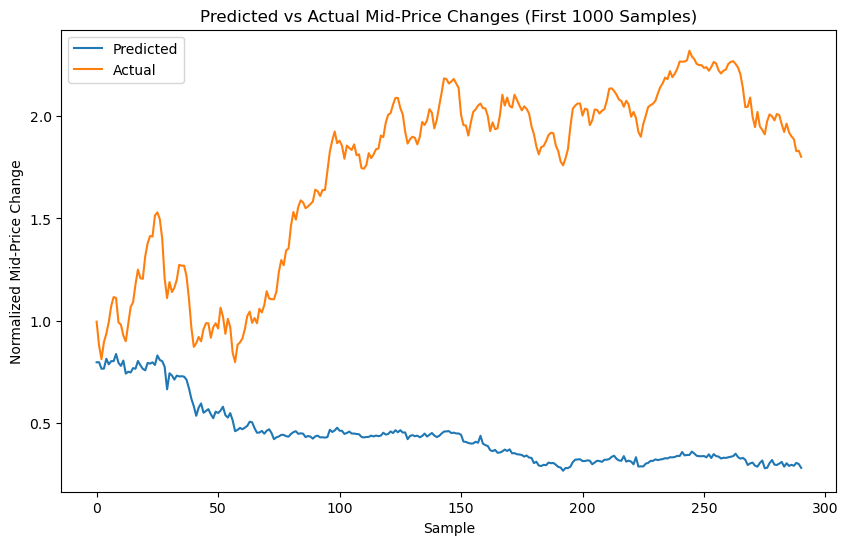

In [74]:
# Cell 8: Evaluate the Transformer Model on Test Data

model.eval()
preds = []
actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        # Check for NaNs or Infs in the batch
        if torch.isnan(batch_X).any() or torch.isinf(batch_X).any():
            raise ValueError("test_loader batch_X contains NaN or Inf values.")
        if torch.isnan(batch_y).any() or torch.isinf(batch_y).any():
            raise ValueError("test_loader batch_y contains NaN or Inf values.")
        
        pred = model(batch_X)
        
        # Check for NaNs or Infs in predictions
        if torch.isnan(pred).any() or torch.isinf(pred).any():
            raise ValueError("Model predictions on test data contain NaN or Inf values.")
        
        preds.append(pred.numpy())
        actuals.append(batch_y.numpy())

# Concatenate all batches
preds = np.concatenate(preds)
actuals = np.concatenate(actuals)

# Calculate Mean Squared Error
mse = np.mean((preds - actuals) ** 2)
print(f"Test MSE: {mse:.6f}")

# Plot predicted vs actual mid_price changes
plt.figure(figsize=(10, 6))
plt.plot(preds[:1000], label='Predicted')
plt.plot(actuals[:1000], label='Actual')
plt.title('Predicted vs Actual Mid-Price Changes (First 1000 Samples)')
plt.xlabel('Sample')
plt.ylabel('Normalized Mid-Price Change')
plt.legend()
plt.show()


In [75]:
# Cell 9: Compute Unscaled Price Changes for the Environment

# price_changes_test was already defined in Cell 4 as the aligned unscaled price changes
# Ensure that 'price_changes_test' corresponds to the testing period

# For clarity, store 'price_changes_test' for later use
actual_price_changes_test = price_changes_test.copy()

print("Computed actual_price_changes_test for the Trading Environment.")


Computed actual_price_changes_test for the Trading Environment.


In [76]:
# Cell 10: Define the Trading Environment

import numpy as np

class TradingEnv:
    def __init__(self, price_changes, initial_capital=1_000_000.0):
        """
        Initialize the trading environment.

        Parameters:
        - price_changes: Array of actual (unscaled) price changes to simulate the environment.
        - initial_capital: Starting portfolio value in dollars.
        """
        self.price_changes = price_changes
        self.initial_capital = initial_capital
        self.reset()

    def reset(self):
        """
        Reset the environment to the initial state.

        Returns:
        - Initial observation.
        """
        self.idx = 0
        self.position = 0  # Current position: -1 (short), 0 (flat), 1 (long)
        self.done = False
        self.profit = 0.0
        self.portfolio_value = self.initial_capital
        return self._get_obs()

    def _get_obs(self):
        """
        Get the current observation.

        Returns:
        - Numpy array representing the observation.
        """
        if self.idx < len(preds):
            # Observation: predicted price movement (prediction - actual)
            return np.array([preds[self.idx] - actuals[self.idx]])
        else:
            return np.array([0.0])

    def step(self, action):
        """
        Take an action in the environment.

        Parameters:
        - action: The action to take (-1: short, 0: flat, 1: long)

        Returns:
        - next_state: The next observation.
        - reward: The reward obtained from taking the action.
        - done: Whether the episode has ended.
        - info: Additional information.
        """
        # Ensure action is valid
        assert action in [-1, 0, 1], "Invalid action."

        # Calculate the reward based on the action and the next price change
        if self.idx < len(self.price_changes):
            price_change = self.price_changes[self.idx]  # Next actual price change
        else:
            price_change = 0.0

        # Update position and portfolio value
        self.position = action
        # To prevent extremely large profits, consider scaling the profit calculation
        self.profit += self.position * price_change * 1000  # Scaled by a factor (e.g., 1000)
        self.portfolio_value = self.initial_capital + self.profit

        # Move to the next time step
        self.idx += 1

        # Check if the episode is done
        if self.idx >= len(self.price_changes):
            self.done = True

        # Get the next observation
        next_state = self._get_obs()

        # Reward is the change in portfolio value
        reward = self.portfolio_value - self.initial_capital

        return next_state, reward, self.done, {}


In [77]:
# Cell 11: Define the Policy Network for Reinforcement Learning

import torch.nn as nn

class PolicyNet(nn.Module):
    def __init__(self, hidden_dim=16):
        """
        Initialize the policy network.
        
        Parameters:
        - hidden_dim: Number of neurons in the hidden layer.
        """
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, hidden_dim),  # Input is 1D: predicted price movement
            nn.ReLU(),
            nn.Linear(hidden_dim, 3)  # Output is 3: logits for actions [-1, 0, 1]
        )
        
        # Initialize weights
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
        
    def forward(self, x):
        """
        Forward pass of the policy network.
        
        Parameters:
        - x: Input tensor.
        
        Returns:
        - Logits for each action.
        """
        return self.fc(x)


In [79]:
# Cell 11: Initialize the Policy Network and Optimizer

policy_net = PolicyNet()
policy_optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)


In [80]:
# Cell 12: Define Action Selection Function

import torch

def select_action(state, policy_net):
    """
    Select an action based on the current state using the policy network.
    
    Parameters:
    - state: The current observation.
    - policy_net: The policy network instance.
    
    Returns:
    - action: The chosen action (-1, 0, 1).
    - prob: The probability of the chosen action.
    """
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Shape: [1, 1]
    logits = policy_net(state_tensor)  # Shape: [1, 3]
    probs = torch.softmax(logits, dim=-1)  # Shape: [1, 3]
    
    # Check for NaNs or Infs in probabilities
    if torch.isnan(probs).any() or torch.isinf(probs).any():
        raise ValueError("Probability tensor contains NaN or Inf values.")
    
    action_idx = torch.multinomial(probs, num_samples=1).item()  # Sample action index
    action_map = {0: -1, 1: 0, 2: 1}  # Mapping from index to action
    action = action_map[action_idx]
    prob = probs[0, action_idx]
    return action, prob


In [84]:
# Cell 13: Train the Policy Network Using Policy Gradient

import torch.optim as optim
from tqdm import tqdm  # For progress bar
import os

# Initialize the policy network and optimizer
policy_net = PolicyNet()
policy_optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)

# Hyperparameters
episodes = 10000  # Increased number of training episodes
gamma = 0.99      # Discount factor
print_interval = 100  # Print status every 100 episodes

# Optional: Directory to save model checkpoints
checkpoint_dir = "policy_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize tqdm progress bar
pbar = tqdm(total=episodes, desc="Training Episodes")

for ep in range(1, episodes + 1):
    env = TradingEnv(price_changes=actual_price_changes_test)  # Initialize environment with actual unscaled price changes
    state = env.reset()
    log_probs = []
    rewards = []
    done = False
    
    while not done:
        try:
            action, prob = select_action(state, policy_net)
        except ValueError as e:
            print(f"Episode {ep}: {e}")
            break  # Skip this episode if there's an error
        
        # Add a small epsilon to prevent log(0)
        log_prob = torch.log(prob + 1e-10)
        
        next_state, reward, done, _ = env.step(action)
        
        log_probs.append(log_prob)
        rewards.append(reward)
        
        state = next_state
    
    # Compute discounted returns
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32)
    
    # Normalize returns
    if returns.std() != 0:
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)
    else:
        returns = returns - returns.mean()
    
    # Compute policy gradient loss
    policy_optimizer.zero_grad()
    loss = 0
    for log_prob, R in zip(log_probs, returns):
        loss -= log_prob * R  # Policy gradient loss
    loss.backward()
    policy_optimizer.step()
    
    # Update progress bar
    pbar.update(1)
    
    # Print status at specified intervals
    if ep % print_interval == 0:
        print(f"Episode {ep}/{episodes}, Final Profit: {env.profit:.2f}")
        
        # Optional: Save the model checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f"policy_net_ep_{ep}.pth")
        torch.save(policy_net.state_dict(), checkpoint_path)
        print(f"Saved model checkpoint to {checkpoint_path}")

pbar.close()
print("Training completed.")


Training Episodes:   1%|          | 102/10000 [00:07<12:22, 13.33it/s]

Episode 100/10000, Final Profit: -2483.49
Saved model checkpoint to policy_checkpoints/policy_net_ep_100.pth


Training Episodes:   2%|▏         | 202/10000 [00:14<12:06, 13.49it/s]

Episode 200/10000, Final Profit: -1789.70
Saved model checkpoint to policy_checkpoints/policy_net_ep_200.pth


Training Episodes:   3%|▎         | 302/10000 [00:22<11:54, 13.58it/s]

Episode 300/10000, Final Profit: 113.04
Saved model checkpoint to policy_checkpoints/policy_net_ep_300.pth


Training Episodes:   4%|▍         | 402/10000 [00:29<11:44, 13.62it/s]

Episode 400/10000, Final Profit: 1268.52
Saved model checkpoint to policy_checkpoints/policy_net_ep_400.pth


Training Episodes:   5%|▌         | 502/10000 [00:36<11:43, 13.51it/s]

Episode 500/10000, Final Profit: 929.32
Saved model checkpoint to policy_checkpoints/policy_net_ep_500.pth


Training Episodes:   6%|▌         | 602/10000 [00:43<11:29, 13.62it/s]

Episode 600/10000, Final Profit: -789.95
Saved model checkpoint to policy_checkpoints/policy_net_ep_600.pth


Training Episodes:   7%|▋         | 702/10000 [00:51<11:34, 13.39it/s]

Episode 700/10000, Final Profit: 36.62
Saved model checkpoint to policy_checkpoints/policy_net_ep_700.pth


Training Episodes:   8%|▊         | 802/10000 [00:58<11:18, 13.55it/s]

Episode 800/10000, Final Profit: -821.87
Saved model checkpoint to policy_checkpoints/policy_net_ep_800.pth


Training Episodes:   9%|▉         | 902/10000 [01:05<11:16, 13.45it/s]

Episode 900/10000, Final Profit: 388.31
Saved model checkpoint to policy_checkpoints/policy_net_ep_900.pth


Training Episodes:  10%|█         | 1002/10000 [01:13<11:06, 13.50it/s]

Episode 1000/10000, Final Profit: -464.63
Saved model checkpoint to policy_checkpoints/policy_net_ep_1000.pth


Training Episodes:  11%|█         | 1102/10000 [01:20<10:57, 13.53it/s]

Episode 1100/10000, Final Profit: 1748.11
Saved model checkpoint to policy_checkpoints/policy_net_ep_1100.pth


Training Episodes:  12%|█▏        | 1202/10000 [01:27<10:49, 13.54it/s]

Episode 1200/10000, Final Profit: 996.55
Saved model checkpoint to policy_checkpoints/policy_net_ep_1200.pth


Training Episodes:  13%|█▎        | 1302/10000 [01:35<10:39, 13.60it/s]

Episode 1300/10000, Final Profit: 1253.51
Saved model checkpoint to policy_checkpoints/policy_net_ep_1300.pth


Training Episodes:  14%|█▍        | 1402/10000 [01:42<10:41, 13.41it/s]

Episode 1400/10000, Final Profit: 443.02
Saved model checkpoint to policy_checkpoints/policy_net_ep_1400.pth


Training Episodes:  15%|█▌        | 1502/10000 [01:49<10:26, 13.57it/s]

Episode 1500/10000, Final Profit: 2776.49
Saved model checkpoint to policy_checkpoints/policy_net_ep_1500.pth


Training Episodes:  16%|█▌        | 1602/10000 [01:57<10:18, 13.58it/s]

Episode 1600/10000, Final Profit: 2609.74
Saved model checkpoint to policy_checkpoints/policy_net_ep_1600.pth


Training Episodes:  17%|█▋        | 1702/10000 [02:04<10:09, 13.61it/s]

Episode 1700/10000, Final Profit: 2768.71
Saved model checkpoint to policy_checkpoints/policy_net_ep_1700.pth


Training Episodes:  18%|█▊        | 1802/10000 [02:11<10:07, 13.50it/s]

Episode 1800/10000, Final Profit: 3319.21
Saved model checkpoint to policy_checkpoints/policy_net_ep_1800.pth


Training Episodes:  19%|█▉        | 1902/10000 [02:18<09:55, 13.59it/s]

Episode 1900/10000, Final Profit: 3277.25
Saved model checkpoint to policy_checkpoints/policy_net_ep_1900.pth


Training Episodes:  20%|██        | 2002/10000 [02:26<09:45, 13.66it/s]

Episode 2000/10000, Final Profit: 4971.98
Saved model checkpoint to policy_checkpoints/policy_net_ep_2000.pth


Training Episodes:  21%|██        | 2102/10000 [02:33<09:40, 13.60it/s]

Episode 2100/10000, Final Profit: -185.09
Saved model checkpoint to policy_checkpoints/policy_net_ep_2100.pth


Training Episodes:  22%|██▏       | 2202/10000 [02:40<09:34, 13.58it/s]

Episode 2200/10000, Final Profit: -593.54
Saved model checkpoint to policy_checkpoints/policy_net_ep_2200.pth


Training Episodes:  23%|██▎       | 2302/10000 [02:47<09:23, 13.65it/s]

Episode 2300/10000, Final Profit: 2000.89
Saved model checkpoint to policy_checkpoints/policy_net_ep_2300.pth


Training Episodes:  24%|██▍       | 2402/10000 [02:55<09:19, 13.58it/s]

Episode 2400/10000, Final Profit: -273.35
Saved model checkpoint to policy_checkpoints/policy_net_ep_2400.pth


Training Episodes:  25%|██▌       | 2502/10000 [03:02<09:08, 13.66it/s]

Episode 2500/10000, Final Profit: 2363.86
Saved model checkpoint to policy_checkpoints/policy_net_ep_2500.pth


Training Episodes:  26%|██▌       | 2602/10000 [03:09<09:05, 13.56it/s]

Episode 2600/10000, Final Profit: 2121.86
Saved model checkpoint to policy_checkpoints/policy_net_ep_2600.pth


Training Episodes:  27%|██▋       | 2702/10000 [03:17<08:54, 13.66it/s]

Episode 2700/10000, Final Profit: 2220.92
Saved model checkpoint to policy_checkpoints/policy_net_ep_2700.pth


Training Episodes:  28%|██▊       | 2802/10000 [03:24<08:44, 13.73it/s]

Episode 2800/10000, Final Profit: 1775.36
Saved model checkpoint to policy_checkpoints/policy_net_ep_2800.pth


Training Episodes:  29%|██▉       | 2902/10000 [03:31<08:40, 13.63it/s]

Episode 2900/10000, Final Profit: 1139.80
Saved model checkpoint to policy_checkpoints/policy_net_ep_2900.pth


Training Episodes:  30%|███       | 3002/10000 [03:38<08:33, 13.63it/s]

Episode 3000/10000, Final Profit: 2858.86
Saved model checkpoint to policy_checkpoints/policy_net_ep_3000.pth


Training Episodes:  31%|███       | 3102/10000 [03:46<08:24, 13.68it/s]

Episode 3100/10000, Final Profit: 2337.07
Saved model checkpoint to policy_checkpoints/policy_net_ep_3100.pth


Training Episodes:  32%|███▏      | 3202/10000 [03:53<08:23, 13.50it/s]

Episode 3200/10000, Final Profit: 410.19
Saved model checkpoint to policy_checkpoints/policy_net_ep_3200.pth


Training Episodes:  33%|███▎      | 3302/10000 [04:00<08:15, 13.51it/s]

Episode 3300/10000, Final Profit: 488.10
Saved model checkpoint to policy_checkpoints/policy_net_ep_3300.pth


Training Episodes:  34%|███▍      | 3402/10000 [04:08<08:06, 13.55it/s]

Episode 3400/10000, Final Profit: 3957.61
Saved model checkpoint to policy_checkpoints/policy_net_ep_3400.pth


Training Episodes:  35%|███▌      | 3502/10000 [04:15<07:59, 13.55it/s]

Episode 3500/10000, Final Profit: 1735.50
Saved model checkpoint to policy_checkpoints/policy_net_ep_3500.pth


Training Episodes:  36%|███▌      | 3602/10000 [04:22<07:52, 13.53it/s]

Episode 3600/10000, Final Profit: 709.87
Saved model checkpoint to policy_checkpoints/policy_net_ep_3600.pth


Training Episodes:  37%|███▋      | 3702/10000 [04:30<07:48, 13.44it/s]

Episode 3700/10000, Final Profit: 2310.12
Saved model checkpoint to policy_checkpoints/policy_net_ep_3700.pth


Training Episodes:  38%|███▊      | 3802/10000 [04:37<07:47, 13.26it/s]

Episode 3800/10000, Final Profit: 2766.30
Saved model checkpoint to policy_checkpoints/policy_net_ep_3800.pth


Training Episodes:  39%|███▉      | 3902/10000 [04:44<07:32, 13.46it/s]

Episode 3900/10000, Final Profit: 818.42
Saved model checkpoint to policy_checkpoints/policy_net_ep_3900.pth


Training Episodes:  40%|████      | 4002/10000 [04:52<07:22, 13.57it/s]

Episode 4000/10000, Final Profit: 1143.83
Saved model checkpoint to policy_checkpoints/policy_net_ep_4000.pth


Training Episodes:  41%|████      | 4102/10000 [04:59<07:17, 13.49it/s]

Episode 4100/10000, Final Profit: 2576.11
Saved model checkpoint to policy_checkpoints/policy_net_ep_4100.pth


Training Episodes:  42%|████▏     | 4202/10000 [05:07<07:16, 13.27it/s]

Episode 4200/10000, Final Profit: 1914.52
Saved model checkpoint to policy_checkpoints/policy_net_ep_4200.pth


Training Episodes:  43%|████▎     | 4302/10000 [05:14<06:58, 13.63it/s]

Episode 4300/10000, Final Profit: 1474.06
Saved model checkpoint to policy_checkpoints/policy_net_ep_4300.pth


Training Episodes:  44%|████▍     | 4402/10000 [05:21<06:49, 13.66it/s]

Episode 4400/10000, Final Profit: 2533.94
Saved model checkpoint to policy_checkpoints/policy_net_ep_4400.pth


Training Episodes:  45%|████▌     | 4502/10000 [05:29<06:41, 13.69it/s]

Episode 4500/10000, Final Profit: 2768.52
Saved model checkpoint to policy_checkpoints/policy_net_ep_4500.pth


Training Episodes:  46%|████▌     | 4602/10000 [05:36<06:36, 13.62it/s]

Episode 4600/10000, Final Profit: 2839.42
Saved model checkpoint to policy_checkpoints/policy_net_ep_4600.pth


Training Episodes:  47%|████▋     | 4702/10000 [05:43<06:27, 13.69it/s]

Episode 4700/10000, Final Profit: 3185.88
Saved model checkpoint to policy_checkpoints/policy_net_ep_4700.pth


Training Episodes:  48%|████▊     | 4802/10000 [05:50<06:20, 13.66it/s]

Episode 4800/10000, Final Profit: 1534.24
Saved model checkpoint to policy_checkpoints/policy_net_ep_4800.pth


Training Episodes:  49%|████▉     | 4902/10000 [05:58<06:11, 13.71it/s]

Episode 4900/10000, Final Profit: 1814.51
Saved model checkpoint to policy_checkpoints/policy_net_ep_4900.pth


Training Episodes:  50%|█████     | 5002/10000 [06:05<06:06, 13.64it/s]

Episode 5000/10000, Final Profit: 3116.58
Saved model checkpoint to policy_checkpoints/policy_net_ep_5000.pth


Training Episodes:  51%|█████     | 5102/10000 [06:12<05:58, 13.67it/s]

Episode 5100/10000, Final Profit: 2898.77
Saved model checkpoint to policy_checkpoints/policy_net_ep_5100.pth


Training Episodes:  52%|█████▏    | 5202/10000 [06:19<05:53, 13.59it/s]

Episode 5200/10000, Final Profit: 1903.93
Saved model checkpoint to policy_checkpoints/policy_net_ep_5200.pth


Training Episodes:  53%|█████▎    | 5302/10000 [06:27<05:44, 13.64it/s]

Episode 5300/10000, Final Profit: 3059.45
Saved model checkpoint to policy_checkpoints/policy_net_ep_5300.pth


Training Episodes:  54%|█████▍    | 5402/10000 [06:34<05:36, 13.68it/s]

Episode 5400/10000, Final Profit: 2580.17
Saved model checkpoint to policy_checkpoints/policy_net_ep_5400.pth


Training Episodes:  55%|█████▌    | 5502/10000 [06:41<05:29, 13.64it/s]

Episode 5500/10000, Final Profit: 2549.32
Saved model checkpoint to policy_checkpoints/policy_net_ep_5500.pth


Training Episodes:  56%|█████▌    | 5602/10000 [06:48<05:24, 13.57it/s]

Episode 5600/10000, Final Profit: 1463.71
Saved model checkpoint to policy_checkpoints/policy_net_ep_5600.pth


Training Episodes:  57%|█████▋    | 5702/10000 [06:56<05:14, 13.65it/s]

Episode 5700/10000, Final Profit: 3830.51
Saved model checkpoint to policy_checkpoints/policy_net_ep_5700.pth


Training Episodes:  58%|█████▊    | 5802/10000 [07:03<05:07, 13.65it/s]

Episode 5800/10000, Final Profit: 2118.99
Saved model checkpoint to policy_checkpoints/policy_net_ep_5800.pth


Training Episodes:  59%|█████▉    | 5902/10000 [07:10<05:03, 13.51it/s]

Episode 5900/10000, Final Profit: 1574.43
Saved model checkpoint to policy_checkpoints/policy_net_ep_5900.pth


Training Episodes:  60%|██████    | 6002/10000 [07:18<04:52, 13.65it/s]

Episode 6000/10000, Final Profit: 2598.08
Saved model checkpoint to policy_checkpoints/policy_net_ep_6000.pth


Training Episodes:  61%|██████    | 6102/10000 [07:25<04:46, 13.62it/s]

Episode 6100/10000, Final Profit: 2426.94
Saved model checkpoint to policy_checkpoints/policy_net_ep_6100.pth


Training Episodes:  62%|██████▏   | 6202/10000 [07:32<04:38, 13.64it/s]

Episode 6200/10000, Final Profit: 1452.97
Saved model checkpoint to policy_checkpoints/policy_net_ep_6200.pth


Training Episodes:  63%|██████▎   | 6302/10000 [07:39<04:30, 13.66it/s]

Episode 6300/10000, Final Profit: 1280.24
Saved model checkpoint to policy_checkpoints/policy_net_ep_6300.pth


Training Episodes:  64%|██████▍   | 6402/10000 [07:47<04:24, 13.60it/s]

Episode 6400/10000, Final Profit: 2095.79
Saved model checkpoint to policy_checkpoints/policy_net_ep_6400.pth


Training Episodes:  65%|██████▌   | 6502/10000 [07:54<04:16, 13.66it/s]

Episode 6500/10000, Final Profit: 1715.21
Saved model checkpoint to policy_checkpoints/policy_net_ep_6500.pth


Training Episodes:  66%|██████▌   | 6602/10000 [08:01<04:09, 13.64it/s]

Episode 6600/10000, Final Profit: 821.50
Saved model checkpoint to policy_checkpoints/policy_net_ep_6600.pth


Training Episodes:  67%|██████▋   | 6702/10000 [08:08<04:16, 12.87it/s]

Episode 6700/10000, Final Profit: 3851.50
Saved model checkpoint to policy_checkpoints/policy_net_ep_6700.pth


Training Episodes:  68%|██████▊   | 6802/10000 [08:16<03:54, 13.66it/s]

Episode 6800/10000, Final Profit: 2022.52
Saved model checkpoint to policy_checkpoints/policy_net_ep_6800.pth


Training Episodes:  69%|██████▉   | 6902/10000 [08:23<03:47, 13.65it/s]

Episode 6900/10000, Final Profit: 1378.69
Saved model checkpoint to policy_checkpoints/policy_net_ep_6900.pth


Training Episodes:  70%|███████   | 7002/10000 [08:30<03:40, 13.60it/s]

Episode 7000/10000, Final Profit: 2667.33
Saved model checkpoint to policy_checkpoints/policy_net_ep_7000.pth


Training Episodes:  71%|███████   | 7102/10000 [08:37<03:32, 13.63it/s]

Episode 7100/10000, Final Profit: 2826.08
Saved model checkpoint to policy_checkpoints/policy_net_ep_7100.pth


Training Episodes:  72%|███████▏  | 7202/10000 [08:45<03:25, 13.59it/s]

Episode 7200/10000, Final Profit: 2158.14
Saved model checkpoint to policy_checkpoints/policy_net_ep_7200.pth


Training Episodes:  73%|███████▎  | 7302/10000 [08:52<03:17, 13.64it/s]

Episode 7300/10000, Final Profit: 1688.23
Saved model checkpoint to policy_checkpoints/policy_net_ep_7300.pth


Training Episodes:  74%|███████▍  | 7402/10000 [08:59<03:10, 13.62it/s]

Episode 7400/10000, Final Profit: 2970.92
Saved model checkpoint to policy_checkpoints/policy_net_ep_7400.pth


Training Episodes:  75%|███████▌  | 7502/10000 [09:07<03:02, 13.70it/s]

Episode 7500/10000, Final Profit: 1069.85
Saved model checkpoint to policy_checkpoints/policy_net_ep_7500.pth


Training Episodes:  76%|███████▌  | 7602/10000 [09:14<02:55, 13.65it/s]

Episode 7600/10000, Final Profit: 4378.91
Saved model checkpoint to policy_checkpoints/policy_net_ep_7600.pth


Training Episodes:  77%|███████▋  | 7702/10000 [09:21<02:47, 13.69it/s]

Episode 7700/10000, Final Profit: 1476.38
Saved model checkpoint to policy_checkpoints/policy_net_ep_7700.pth


Training Episodes:  78%|███████▊  | 7802/10000 [09:28<02:40, 13.69it/s]

Episode 7800/10000, Final Profit: 2201.81
Saved model checkpoint to policy_checkpoints/policy_net_ep_7800.pth


Training Episodes:  79%|███████▉  | 7902/10000 [09:35<02:33, 13.67it/s]

Episode 7900/10000, Final Profit: 1972.26
Saved model checkpoint to policy_checkpoints/policy_net_ep_7900.pth


Training Episodes:  80%|████████  | 8002/10000 [09:43<02:25, 13.70it/s]

Episode 8000/10000, Final Profit: 1221.13
Saved model checkpoint to policy_checkpoints/policy_net_ep_8000.pth


Training Episodes:  81%|████████  | 8102/10000 [09:50<02:18, 13.66it/s]

Episode 8100/10000, Final Profit: 1162.02
Saved model checkpoint to policy_checkpoints/policy_net_ep_8100.pth


Training Episodes:  82%|████████▏ | 8202/10000 [09:57<02:11, 13.65it/s]

Episode 8200/10000, Final Profit: 1519.56
Saved model checkpoint to policy_checkpoints/policy_net_ep_8200.pth


Training Episodes:  83%|████████▎ | 8302/10000 [10:05<02:04, 13.68it/s]

Episode 8300/10000, Final Profit: 912.32
Saved model checkpoint to policy_checkpoints/policy_net_ep_8300.pth


Training Episodes:  84%|████████▍ | 8402/10000 [10:12<01:57, 13.64it/s]

Episode 8400/10000, Final Profit: 2310.52
Saved model checkpoint to policy_checkpoints/policy_net_ep_8400.pth


Training Episodes:  85%|████████▌ | 8502/10000 [10:19<01:49, 13.65it/s]

Episode 8500/10000, Final Profit: 1500.06
Saved model checkpoint to policy_checkpoints/policy_net_ep_8500.pth


Training Episodes:  86%|████████▌ | 8602/10000 [10:26<01:42, 13.59it/s]

Episode 8600/10000, Final Profit: -269.20
Saved model checkpoint to policy_checkpoints/policy_net_ep_8600.pth


Training Episodes:  87%|████████▋ | 8702/10000 [10:34<01:35, 13.62it/s]

Episode 8700/10000, Final Profit: 1852.60
Saved model checkpoint to policy_checkpoints/policy_net_ep_8700.pth


Training Episodes:  88%|████████▊ | 8802/10000 [10:41<01:27, 13.68it/s]

Episode 8800/10000, Final Profit: -232.27
Saved model checkpoint to policy_checkpoints/policy_net_ep_8800.pth


Training Episodes:  89%|████████▉ | 8902/10000 [10:48<01:20, 13.63it/s]

Episode 8900/10000, Final Profit: 2182.19
Saved model checkpoint to policy_checkpoints/policy_net_ep_8900.pth


Training Episodes:  90%|█████████ | 9002/10000 [10:56<01:13, 13.61it/s]

Episode 9000/10000, Final Profit: -454.50
Saved model checkpoint to policy_checkpoints/policy_net_ep_9000.pth


Training Episodes:  91%|█████████ | 9102/10000 [11:03<01:05, 13.63it/s]

Episode 9100/10000, Final Profit: 1600.37
Saved model checkpoint to policy_checkpoints/policy_net_ep_9100.pth


Training Episodes:  92%|█████████▏| 9202/10000 [11:10<00:58, 13.60it/s]

Episode 9200/10000, Final Profit: 628.39
Saved model checkpoint to policy_checkpoints/policy_net_ep_9200.pth


Training Episodes:  93%|█████████▎| 9302/10000 [11:17<00:51, 13.58it/s]

Episode 9300/10000, Final Profit: 3228.12
Saved model checkpoint to policy_checkpoints/policy_net_ep_9300.pth


Training Episodes:  94%|█████████▍| 9402/10000 [11:25<00:43, 13.64it/s]

Episode 9400/10000, Final Profit: 3614.14
Saved model checkpoint to policy_checkpoints/policy_net_ep_9400.pth


Training Episodes:  95%|█████████▌| 9502/10000 [11:32<00:36, 13.62it/s]

Episode 9500/10000, Final Profit: 3050.42
Saved model checkpoint to policy_checkpoints/policy_net_ep_9500.pth


Training Episodes:  96%|█████████▌| 9602/10000 [11:39<00:29, 13.69it/s]

Episode 9600/10000, Final Profit: 2165.86
Saved model checkpoint to policy_checkpoints/policy_net_ep_9600.pth


Training Episodes:  97%|█████████▋| 9702/10000 [11:46<00:21, 13.66it/s]

Episode 9700/10000, Final Profit: 2157.26
Saved model checkpoint to policy_checkpoints/policy_net_ep_9700.pth


Training Episodes:  98%|█████████▊| 9802/10000 [11:54<00:14, 13.64it/s]

Episode 9800/10000, Final Profit: 2192.63
Saved model checkpoint to policy_checkpoints/policy_net_ep_9800.pth


Training Episodes:  99%|█████████▉| 9902/10000 [12:01<00:07, 13.64it/s]

Episode 9900/10000, Final Profit: 1976.41
Saved model checkpoint to policy_checkpoints/policy_net_ep_9900.pth


Training Episodes: 100%|██████████| 10000/10000 [12:08<00:00, 13.73it/s]

Episode 10000/10000, Final Profit: 3555.97
Saved model checkpoint to policy_checkpoints/policy_net_ep_10000.pth
Training completed.


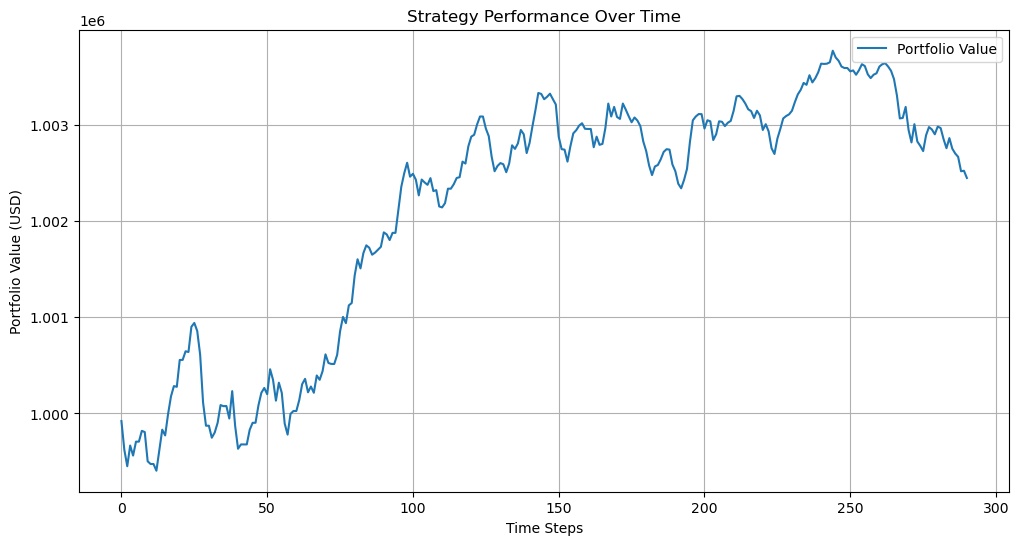

Initial Investment: 1000000.00
Final Portfolio Value: 1002451.35
Profit/Loss: 2451.35
Win Rate: 88.32%


In [85]:
# Cell 14: Backtesting the Trained Policy

# Initialize environment with an initial investment of 1,000,000 and actual unscaled price changes
env = TradingEnv(price_changes=actual_price_changes_test, initial_capital=1_000_000.0)
state = env.reset()

positions = []           # To store actions
portfolio_values = []    # To store portfolio value over time
actions_taken = []       # To store actions for analysis

while True:
    try:
        action, _ = select_action(state, policy_net)
    except ValueError as e:
        print(f"Backtesting Error: {e}")
        break  # Exit the loop if there's an error
    
    positions.append(action)
    next_state, reward, done, _ = env.step(action)
    portfolio_values.append(env.portfolio_value)
    actions_taken.append(action)
    state = next_state
    if done:
        break

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.title("Strategy Performance Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value (USD)")
plt.legend()
plt.grid(True)
plt.show()

# Display final statistics
final_portfolio_value = portfolio_values[-1]
profit_or_loss = final_portfolio_value - env.initial_capital
win_rate = np.mean(np.array(portfolio_values) > env.initial_capital) * 100  # Percentage

print(f"Initial Investment: {env.initial_capital:.2f}")
print(f"Final Portfolio Value: {final_portfolio_value:.2f}")
print(f"Profit/Loss: {profit_or_loss:.2f}")
print(f"Win Rate: {win_rate:.2f}%")


/tmp/ipykernel_155/3634290540.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=action_labels_mapped, y=action_counts.values, palette='viridis')


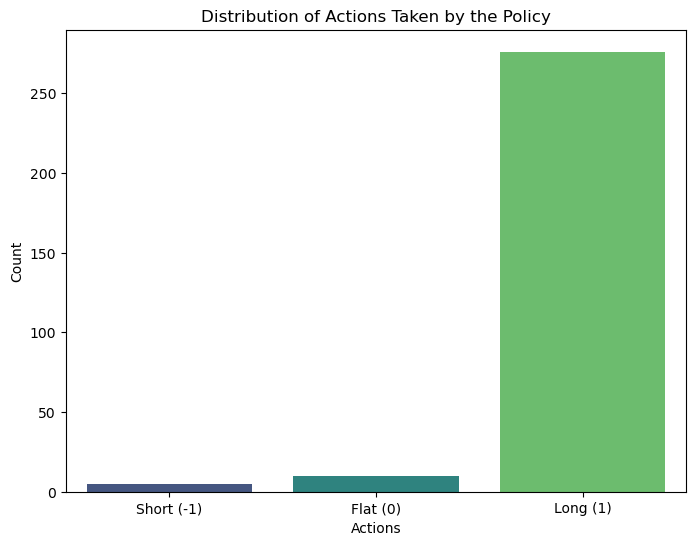

In [86]:
# Cell 15: Analyze Actions Taken

# Count the number of each action
action_counts = pd.Series(actions_taken).value_counts().sort_index()

# Map actions to labels
action_labels = { -1: 'Short (-1)', 0: 'Flat (0)', 1: 'Long (1)' }
action_labels_mapped = [action_labels[a] for a in action_counts.index]

# Plot the distribution of actions
plt.figure(figsize=(8, 6))
sns.barplot(x=action_labels_mapped, y=action_counts.values, palette='viridis')
plt.title("Distribution of Actions Taken by the Policy")
plt.xlabel("Actions")
plt.ylabel("Count")
plt.show()


In [ ]:
# Cell 16: Save and Load Models (Optional)

# Save the transformer model
torch.save(model.state_dict(), 'transformer_model.pth')
print("Transformer model saved.")

# Save the policy network
torch.save(policy_net.state_dict(), 'policy_net.pth')
print("Policy network saved.")

# To load the models later:
# model.load_state_dict(torch.load('transformer_model.pth'))
# policy_net.load_state_dict(torch.load('policy_net.pth'))
